### 01_loading&preprocessing_h5ad 

#### **Preprocessing and quality control of SEA-AD single-nucleus and single-cell RNA-seq data**  

#### **Overview**  

This iPython notebook processes **single-cell (scRNA-seq) and single-nucleus RNA sequencing (snRNA-seq)** data from the **Seattle Alzheimer’s Disease Brain Cell Atlas (SEA-AD)**, specifically from the **middle temporal gyrus (MTG)** of human brains. Instead of directly downloading the dataset from the SEA-AD repository, this analysis uses the preprocessed version available on CELLxGENE. The dataset includes both Alzheimer’s disease (AD) patients and controls, and comprises 1.3 million cells/nuclei. 

#### **Objectives**  

1. Load and preprocess the .h5ad dataset from the SEA-AD Atlas.  
2. Separate single-cell and single-nucleus data to ensure technology-specific preprocessing.  
3. Perform quality control (QC) independently for each technology, filtering low-quality cells/nuclei based on:  
   - Gene count thresholds: Extreme outliers are removed dynamically using quantile-based thresholds.  
   - Mitochondrial gene content: Cells/nuclei with high mitochondrial RNA percentages are filtered dynamically. 
4. Normalize gene expression separately for each technology to ensure comparability across datasets.  
5. Evaluate data distributions before and after preprocessing, using statistical summaries, histograms, boxplots, and correlation matrices.   
#### **Required libraries**  

Before running this notebook, ensure that the following libraries are installed:  

```python
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
```

#### **Notes**  

- This preprocessing step ensures that the dataset is clean and ready for downstream analyses.  
- Filtering thresholds are data-driven and separately optimized for scRNA-seq and snRNA-seq, avoiding arbitrary cutoffs. 

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# Define file paths
data_raw_path = "/home/silvanac/NeuroNet_AD/data/raw/whole_taxonomy_MTG_AD.h5ad"

# Load the dataset without loading everything into RAM
adata = sc.read_h5ad(data_raw_path, backed="r")

# View dataset dimensions
print(adata.shape)

(1378211, 36412)


In [4]:
# Extract a sample of 5000 cells to work with
adata_sample = adata[:5000, :].to_memory()

# Verify the new sample
print(adata_sample.shape)

(5000, 36412)


In [5]:
# Split the dataset into scRNA-seq and snRNA-seq
adata_scrna = adata_sample[adata_sample.obs["assay"] == "10x 3' v3"].copy()
adata_snrna = adata_sample[adata_sample.obs["assay"] == "10x multiome"].copy()

# Verify the number of cells in each dataset
print(f"scRNA-seq: {adata_scrna.n_obs} cells")
print(f"snRNA-seq: {adata_snrna.n_obs} nuclei")

scRNA-seq: 4464 cells
snRNA-seq: 536 nuclei


In [6]:
 ################################## General inspection of AnnData object ################################## 

In [7]:
# Inspect the general structure of the AnnData object
print(f"General information about the AnnData object:")
print(adata_sample)

General information about the AnnData object:
AnnData object with n_obs × n_vars = 5000 × 36412
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'development_stage_ontology_term_id', 'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_referen

In [8]:
# Review the first rows of gene metadata (var)
print("Gene metadata (adata.var):")
print(adata_sample.var.head())

Gene metadata (adata.var):
                 feature_is_filtered feature_name feature_reference  \
ENSG00000000003                False       TSPAN6    NCBITaxon:9606   
ENSG00000000005                False         TNMD    NCBITaxon:9606   
ENSG00000000419                False         DPM1    NCBITaxon:9606   
ENSG00000000457                False        SCYL3    NCBITaxon:9606   
ENSG00000000460                False     C1orf112    NCBITaxon:9606   

                feature_biotype feature_length    feature_type  
ENSG00000000003            gene           2396  protein_coding  
ENSG00000000005            gene            873  protein_coding  
ENSG00000000419            gene           1262  protein_coding  
ENSG00000000457            gene           2916  protein_coding  
ENSG00000000460            gene           2661  protein_coding  


In [9]:
# Display the keys within the uns structure (unstructured data)
print("Contents of adata.uns (non-tabular data):")
print(adata_sample.uns.keys())

Contents of adata.uns (non-tabular data):
dict_keys(['ADNC_colors', 'APOE4 status_colors', 'Age at death_colors', 'Braak stage_colors', 'CERAD score_colors', 'Cognitive status_colors', 'Great Apes Metadata', 'LATE-NC stage_colors', 'Lewy body disease pathology_colors', 'Microinfarct pathology_colors', 'PMI_colors', 'Subclass_colors', 'Supertype_colors', 'Thal phase_colors', 'UW Clinical Metadata', 'Years of education_colors', 'batch_condition', 'citation', 'default_embedding', 'neighbors', 'schema_reference', 'schema_version', 'title', 'umap'])


In [10]:
# Check additional matrices stored in obsm 
print("Additional matrices in adata.obsm:")
print(adata_sample.obsm.keys())

Additional matrices in adata.obsm:
KeysView(AxisArrays with keys: X_scVI, X_umap)


In [11]:
# Check if raw (unprocessed) data is stored in adata.raw
print("Data in adata.raw:")
print("Present" if adata_sample.raw is not None else "Not present")

Data in adata.raw:
Present


In [12]:
 ##########################################################################################################

In [13]:
# Check the columns present in scRNA-seq metadata before modifications
print("Columns in adata_scrna.obs before correction:")
print(adata_scrna.obs.columns)

# Define the 'total_counts' column using the total number of detected RNA molecules (UMIs) per cell
adata_scrna.obs["total_counts"] = adata_scrna.obs["Number of UMIs"]

# Confirm that 'total_counts' has been successfully added
print("Columns in adata_scrna.obs after adding 'total_counts':")
print(adata_scrna.obs.columns)


# Check the columns present in snRNA-seq metadata before modifications
print("Columns in adata_snrna.obs before correction:")
print(adata_snrna.obs.columns)

# Define the 'total_counts' column using the total number of detected RNA molecules (UMIs) per nucleus
adata_snrna.obs["total_counts"] = adata_snrna.obs["Number of UMIs"]

# Confirm that 'total_counts' has been successfully added
print("Columns in adata_snrna.obs after adding 'total_counts':")
print(adata_snrna.obs.columns)

Columns in adata_scrna.obs before correction:
Index(['assay_ontology_term_id', 'cell_type_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference',
       'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education',
       'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score',
       'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage',
       'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI',
       'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs',
       'suspension_type', 'development_stage_ontology_term_id',
       'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid'],
      dtype='object')
Columns 

In [14]:
# Identify mitochondrial genes in the feature matrix for scRNA-seq
adata_scrna.var["mt"] = adata_scrna.var["feature_name"].str.startswith("MT-")

# Count the total number of mitochondrial genes detected in scRNA-seq
print(f"Number of mitochondrial genes identified in scRNA-seq: {adata_scrna.var['mt'].sum()}")

# Calculate the total mitochondrial RNA expression per cell in scRNA-seq
mt_counts_scrna = adata_scrna[:, adata_scrna.var["mt"]].X.sum(axis=1)

# Ensure that mt_counts_scrna is a one-dimensional array
if isinstance(mt_counts_scrna, np.matrix) or len(mt_counts_scrna.shape) > 1:
    mt_counts_scrna = np.asarray(mt_counts_scrna).flatten()

# Compute the percentage of mitochondrial RNA per cell in scRNA-seq
adata_scrna.obs["pct_counts_mt"] = (mt_counts_scrna / adata_scrna.obs["total_counts"].values) * 100

# Verify that the relevant columns have been successfully added to scRNA-seq
print("Final columns in adata_scrna.obs:")
print(adata_scrna.obs.columns)


# Identify mitochondrial genes in the feature matrix for snRNA-seq
adata_snrna.var["mt"] = adata_snrna.var["feature_name"].str.startswith("MT-")

# Count the total number of mitochondrial genes detected in snRNA-seq
print(f"Number of mitochondrial genes identified in snRNA-seq: {adata_snrna.var['mt'].sum()}")

# Calculate the total mitochondrial RNA expression per nucleus in snRNA-seq
mt_counts_snrna = adata_snrna[:, adata_snrna.var["mt"]].X.sum(axis=1)

# Ensure that mt_counts_snrna is a one-dimensional array
if isinstance(mt_counts_snrna, np.matrix) or len(mt_counts_snrna.shape) > 1:
    mt_counts_snrna = np.asarray(mt_counts_snrna).flatten()

# Compute the percentage of mitochondrial RNA per nucleus in snRNA-seq
adata_snrna.obs["pct_counts_mt"] = (mt_counts_snrna / adata_snrna.obs["total_counts"].values) * 100

# Verify that the relevant columns have been successfully added to snRNA-seq
print("Final columns in adata_snrna.obs:")
print(adata_snrna.obs.columns)

Number of mitochondrial genes identified in scRNA-seq: 13
Final columns in adata_scrna.obs:
Index(['assay_ontology_term_id', 'cell_type_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference',
       'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education',
       'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score',
       'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage',
       'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI',
       'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs',
       'suspension_type', 'development_stage_ontology_term_id',
       'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observ

In [15]:
# List mitochondrial genes in scRNA-seq
mt_genes_scrna = adata_scrna.var.index[adata_scrna.var["mt"]].tolist()
print("Mitochondrial genes in scRNA-seq:", mt_genes_scrna)

# List mitochondrial genes in snRNA-seq
mt_genes_snrna = adata_snrna.var.index[adata_snrna.var["mt"]].tolist()
print("Mitochondrial genes in snRNA-seq:", mt_genes_snrna)

Mitochondrial genes in scRNA-seq: ['ENSG00000198695', 'ENSG00000198712', 'ENSG00000198727', 'ENSG00000198763', 'ENSG00000198786', 'ENSG00000198804', 'ENSG00000198840', 'ENSG00000198886', 'ENSG00000198888', 'ENSG00000198899', 'ENSG00000198938', 'ENSG00000212907', 'ENSG00000228253']
Mitochondrial genes in snRNA-seq: ['ENSG00000198695', 'ENSG00000198712', 'ENSG00000198727', 'ENSG00000198763', 'ENSG00000198786', 'ENSG00000198804', 'ENSG00000198840', 'ENSG00000198886', 'ENSG00000198888', 'ENSG00000198899', 'ENSG00000198938', 'ENSG00000212907', 'ENSG00000228253']


Generating violin plots for scRNA-seq...


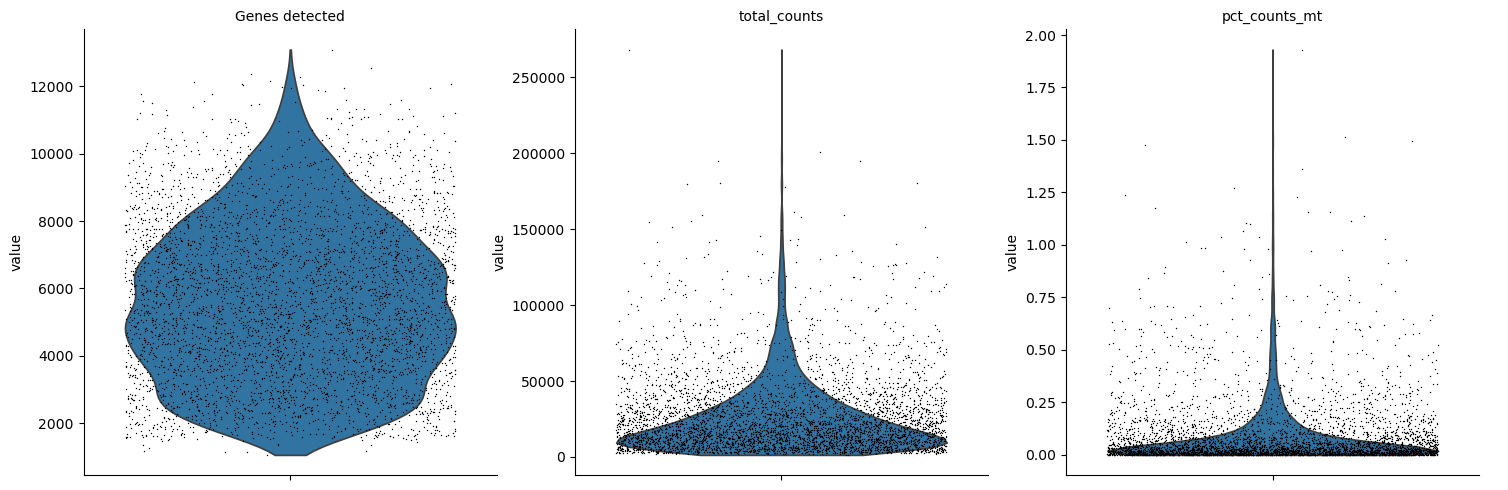

Generating violin plots for snRNA-seq...


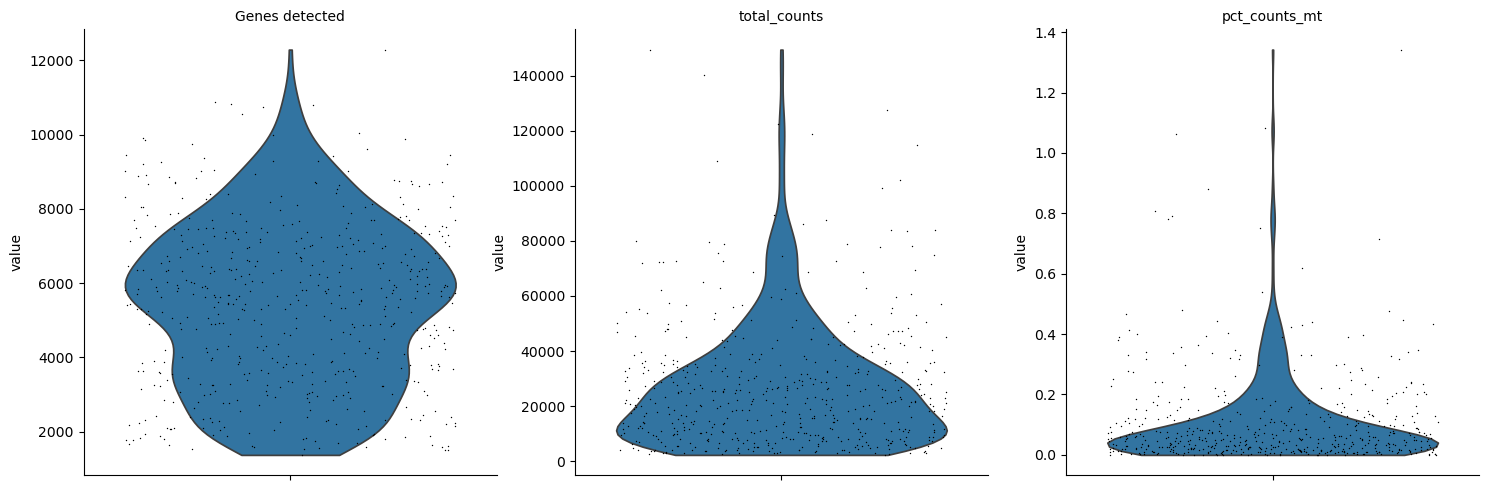

In [16]:
# Generate violin plots to visualize the distribution of key metrics in scRNA-seq
print("Generating violin plots for scRNA-seq...")
sc.pl.violin(
    adata_scrna,  # Dataset containing only single-cell RNA-seq data
    ["Genes detected", "total_counts", "pct_counts_mt"],  
    jitter=0.4,  # Adds slight random noise to prevent overplotting of individual points
    multi_panel=True  # Displays all plots in a single figure
)

# Generate violin plots to visualize the distribution of key metrics in snRNA-seq
print("Generating violin plots for snRNA-seq...")
sc.pl.violin(
    adata_snrna,  # Dataset containing only single-nucleus RNA-seq data
    ["Genes detected", "total_counts", "pct_counts_mt"],  
    jitter=0.4,  
    multi_panel=True  
)

In [17]:
# Check for null or missing values in scRNA-seq dataset
print("Checking for missing values in scRNA-seq dataset:")
print(adata_scrna.obs[["Genes detected", "total_counts", "pct_counts_mt"]].isnull().sum())

# Check for null or missing values in snRNA-seq dataset
print("Checking for missing values in snRNA-seq dataset:")
print(adata_snrna.obs[["Genes detected", "total_counts", "pct_counts_mt"]].isnull().sum())

Checking for missing values in scRNA-seq dataset:
Genes detected    0
total_counts      0
pct_counts_mt     0
dtype: int64
Checking for missing values in snRNA-seq dataset:
Genes detected    0
total_counts      0
pct_counts_mt     0
dtype: int64


In [18]:
# Generate basic descriptive statistics for scRNA-seq dataset
print("Descriptive statistics for scRNA-seq dataset:")
print(adata_scrna.obs[["Genes detected", "total_counts", "pct_counts_mt"]].describe())

# Generate basic descriptive statistics for snRNA-seq dataset
print("Descriptive statistics for snRNA-seq dataset:")
print(adata_snrna.obs[["Genes detected", "total_counts", "pct_counts_mt"]].describe())

Descriptive statistics for scRNA-seq dataset:
       Genes detected   total_counts  pct_counts_mt
count     4464.000000    4464.000000    4464.000000
mean      5564.818100   25984.663082       0.089757
std       2319.381669   24722.916986       0.155810
min       1056.000000    1398.000000       0.000000
25%       3720.000000    9691.750000       0.010462
50%       5415.500000   18543.500000       0.032766
75%       7199.500000   33327.000000       0.097286
max      13091.000000  268068.000000       1.930483
Descriptive statistics for snRNA-seq dataset:
       Genes detected   total_counts  pct_counts_mt
count      536.000000     536.000000     536.000000
mean      5408.027985   26526.375000       0.105210
std       2180.056005   22340.549795       0.151638
min       1379.000000    2278.000000       0.000000
25%       3641.000000   10273.750000       0.019499
50%       5606.500000   21342.000000       0.054334
75%       6990.250000   35000.000000       0.123509
max      12285.000000  1

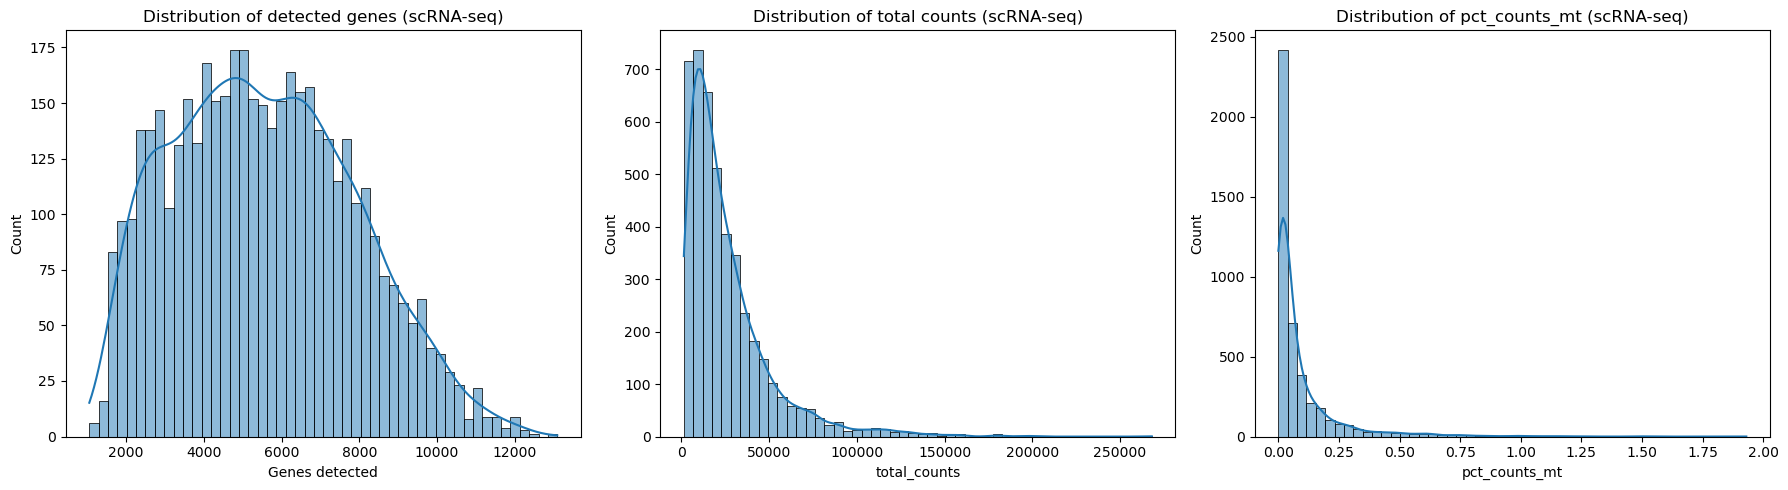

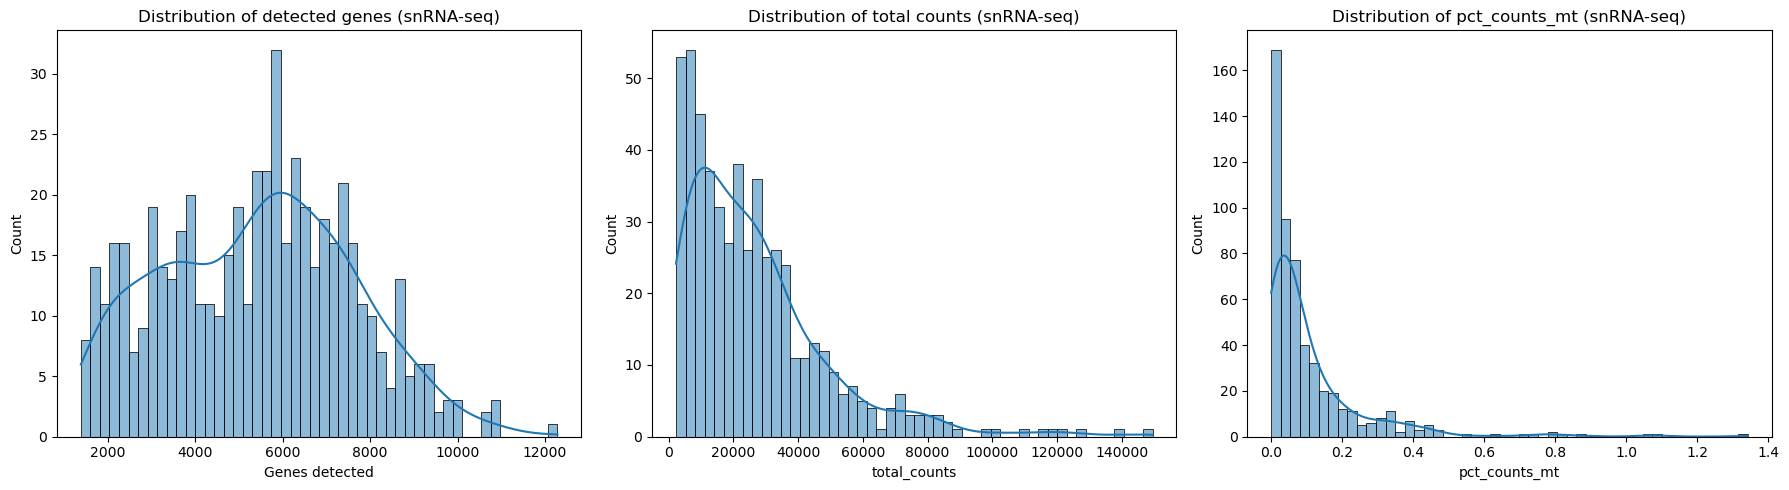

In [19]:
# Create histograms to visualize the data distribution for scRNA-seq
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(adata_scrna.obs["Genes detected"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of detected genes (scRNA-seq)")

sns.histplot(adata_scrna.obs["total_counts"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of total counts (scRNA-seq)")

sns.histplot(adata_scrna.obs["pct_counts_mt"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Distribution of pct_counts_mt (scRNA-seq)")

plt.tight_layout()
plt.show()


# Create histograms to visualize the data distribution for snRNA-seq
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(adata_snrna.obs["Genes detected"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of detected genes (snRNA-seq)")

sns.histplot(adata_snrna.obs["total_counts"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of total counts (snRNA-seq)")

sns.histplot(adata_snrna.obs["pct_counts_mt"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Distribution of pct_counts_mt (snRNA-seq)")

plt.tight_layout()
plt.show()

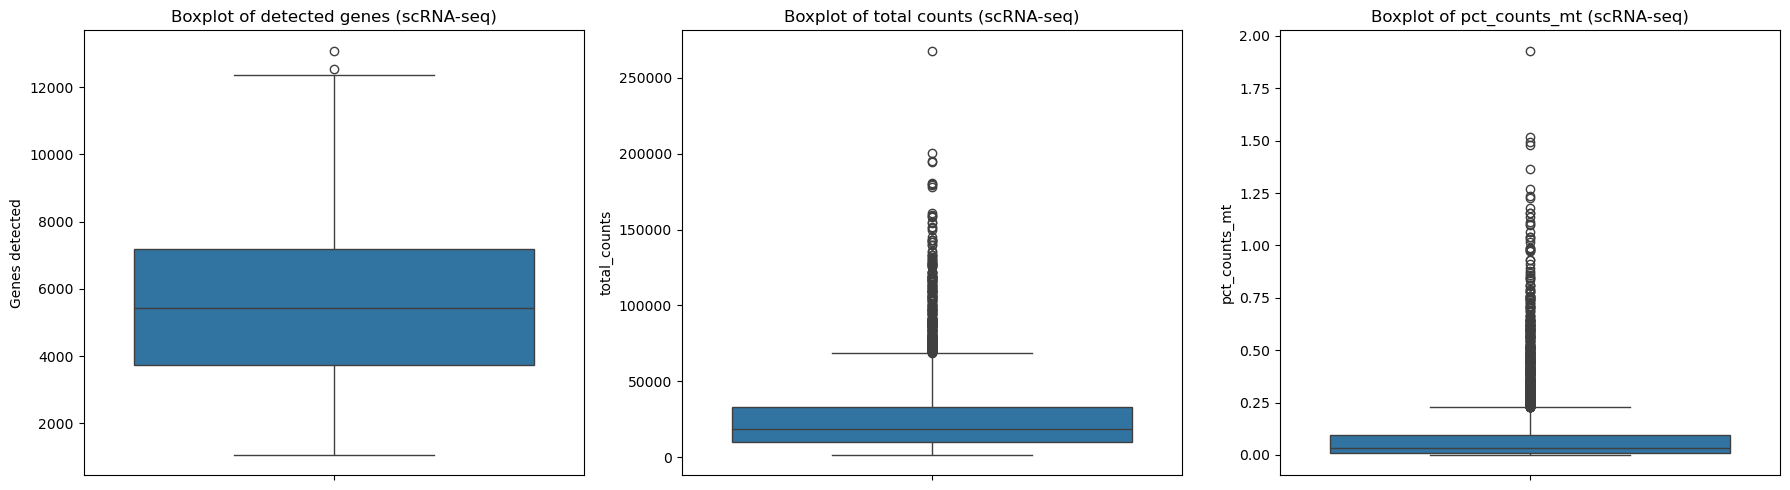

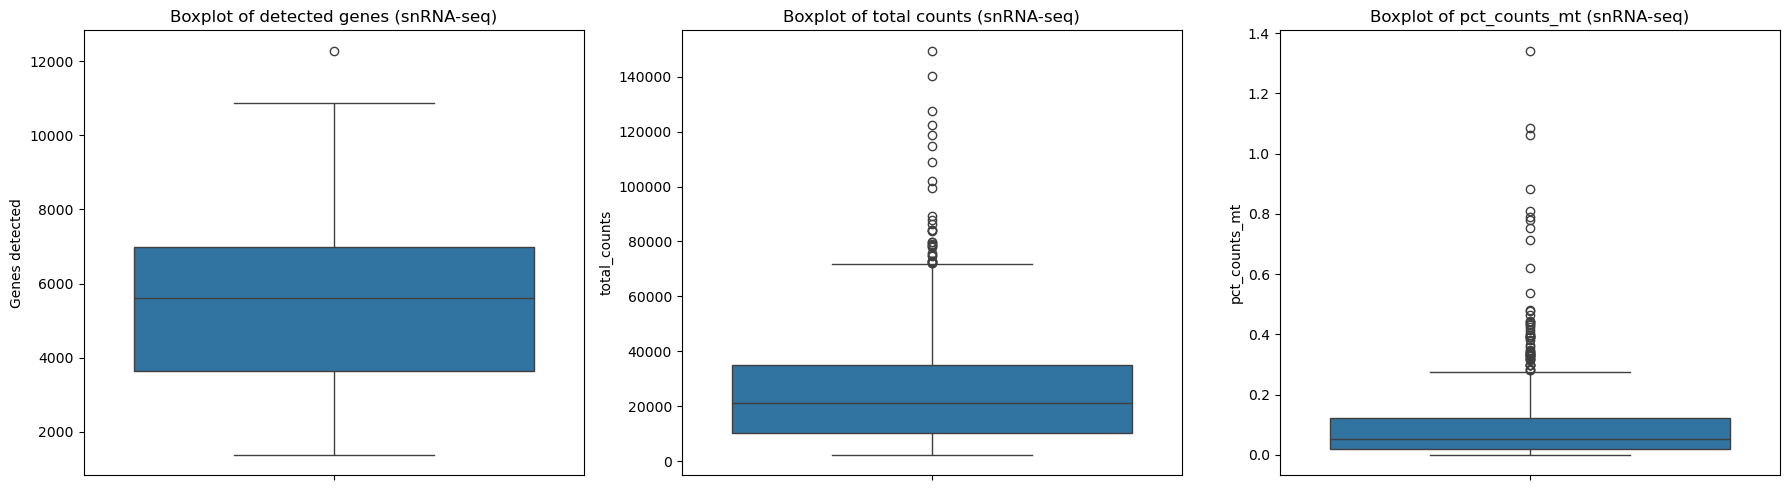

In [20]:
# Create boxplots to visualize outliers for scRNA-seq dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=adata_scrna.obs["Genes detected"], ax=axes[0])
axes[0].set_title("Boxplot of detected genes (scRNA-seq)")

sns.boxplot(y=adata_scrna.obs["total_counts"], ax=axes[1])
axes[1].set_title("Boxplot of total counts (scRNA-seq)")

sns.boxplot(y=adata_scrna.obs["pct_counts_mt"], ax=axes[2])
axes[2].set_title("Boxplot of pct_counts_mt (scRNA-seq)")

plt.tight_layout()
plt.show()


# Create boxplots to visualize outliers for snRNA-seq dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=adata_snrna.obs["Genes detected"], ax=axes[0])
axes[0].set_title("Boxplot of detected genes (snRNA-seq)")

sns.boxplot(y=adata_snrna.obs["total_counts"], ax=axes[1])
axes[1].set_title("Boxplot of total counts (snRNA-seq)")

sns.boxplot(y=adata_snrna.obs["pct_counts_mt"], ax=axes[2])
axes[2].set_title("Boxplot of pct_counts_mt (snRNA-seq)")

plt.tight_layout()
plt.show()

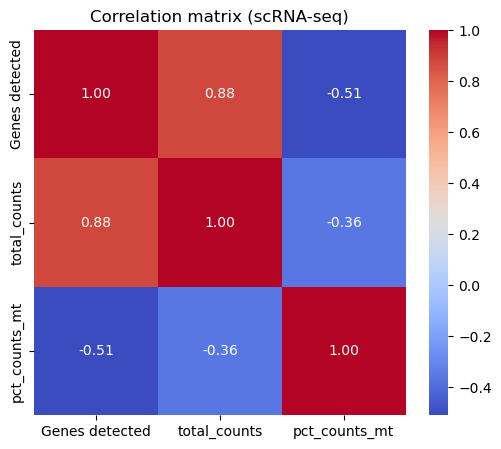

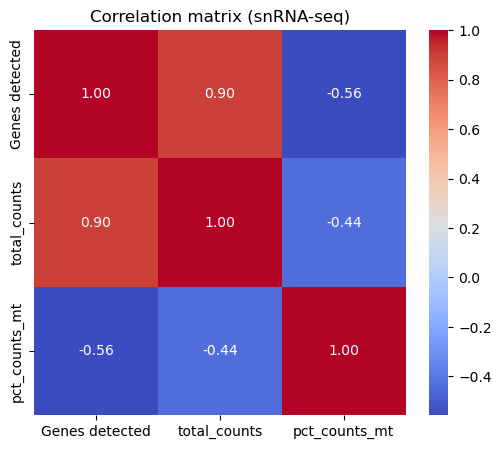

In [21]:
# Compute correlation matrix for scRNA-seq
corr_matrix_scrna = adata_scrna.obs[["Genes detected", "total_counts", "pct_counts_mt"]].corr()

# Plot correlation heatmap for scRNA-seq
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_scrna, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix (scRNA-seq)")
plt.show()


# Compute correlation matrix for snRNA-seq
corr_matrix_snrna = adata_snrna.obs[["Genes detected", "total_counts", "pct_counts_mt"]].corr()

# Plot correlation heatmap for snRNA-seq
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_snrna, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix (snRNA-seq)")
plt.show()

In [22]:
# Display the first columns of adata_sample.var to look for useful labels  
print(adata_sample.var.columns)

Index(['feature_is_filtered', 'feature_name', 'feature_reference',
       'feature_biotype', 'feature_length', 'feature_type'],
      dtype='object')


In [23]:
# Display the first columns of adata_scrna.var to check for useful labels
print("Columns in adata_scrna.var:")
print(adata_scrna.var.columns)

# Remove mitochondrial genes from scRNA-seq dataset
adata_scrna = adata_scrna[:, ~adata_scrna.var["mt"]]

# Confirm that mitochondrial genes were successfully filtered in scRNA-seq
print(f"Number of genes after filtering in scRNA-seq: {adata_scrna.shape[1]}")


# Display the first columns of adata_snrna.var to check for useful labels
print("Columns in adata_snrna.var:")
print(adata_snrna.var.columns)

# Remove mitochondrial genes from snRNA-seq dataset
adata_snrna = adata_snrna[:, ~adata_snrna.var["mt"]]

# Confirm that mitochondrial genes were successfully filtered in snRNA-seq
print(f"Number of genes after filtering in snRNA-seq: {adata_snrna.shape[1]}")

Columns in adata_scrna.var:
Index(['feature_is_filtered', 'feature_name', 'feature_reference',
       'feature_biotype', 'feature_length', 'feature_type', 'mt'],
      dtype='object')
Number of genes after filtering in scRNA-seq: 36399
Columns in adata_snrna.var:
Index(['feature_is_filtered', 'feature_name', 'feature_reference',
       'feature_biotype', 'feature_length', 'feature_type', 'mt'],
      dtype='object')
Number of genes after filtering in snRNA-seq: 36399


In [24]:
# Make a real copy of scRNA-seq dataset to avoid warnings when modifying .obs
adata_scrna = adata_scrna.copy()

# Recalculate total expression without mitochondrial genes in scRNA-seq
adata_scrna.obs["total_counts"] = adata_scrna.X.sum(axis=1)

# Assign a new mitochondrial expression percentage (should be 0 in all cells)
adata_scrna.obs["pct_counts_mt"] = 0.0

# Verify that pct_counts_mt is indeed 0 in all scRNA-seq cells
print("Summary statistics for pct_counts_mt in scRNA-seq:")
print(adata_scrna.obs["pct_counts_mt"].describe())


# Make a real copy of snRNA-seq dataset to avoid warnings when modifying .obs
adata_snrna = adata_snrna.copy()

# Recalculate total expression without mitochondrial genes in snRNA-seq
adata_snrna.obs["total_counts"] = adata_snrna.X.sum(axis=1)

# Assign a new mitochondrial expression percentage (should be 0 in all nuclei)
adata_snrna.obs["pct_counts_mt"] = 0.0

# Verify that pct_counts_mt is indeed 0 in all snRNA-seq nuclei
print("Summary statistics for pct_counts_mt in snRNA-seq:")
print(adata_snrna.obs["pct_counts_mt"].describe())

Summary statistics for pct_counts_mt in scRNA-seq:
count    4464.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: pct_counts_mt, dtype: float64
Summary statistics for pct_counts_mt in snRNA-seq:
count    536.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: pct_counts_mt, dtype: float64


Generating violin plots for scRNA-seq after mitochondrial gene filtering...


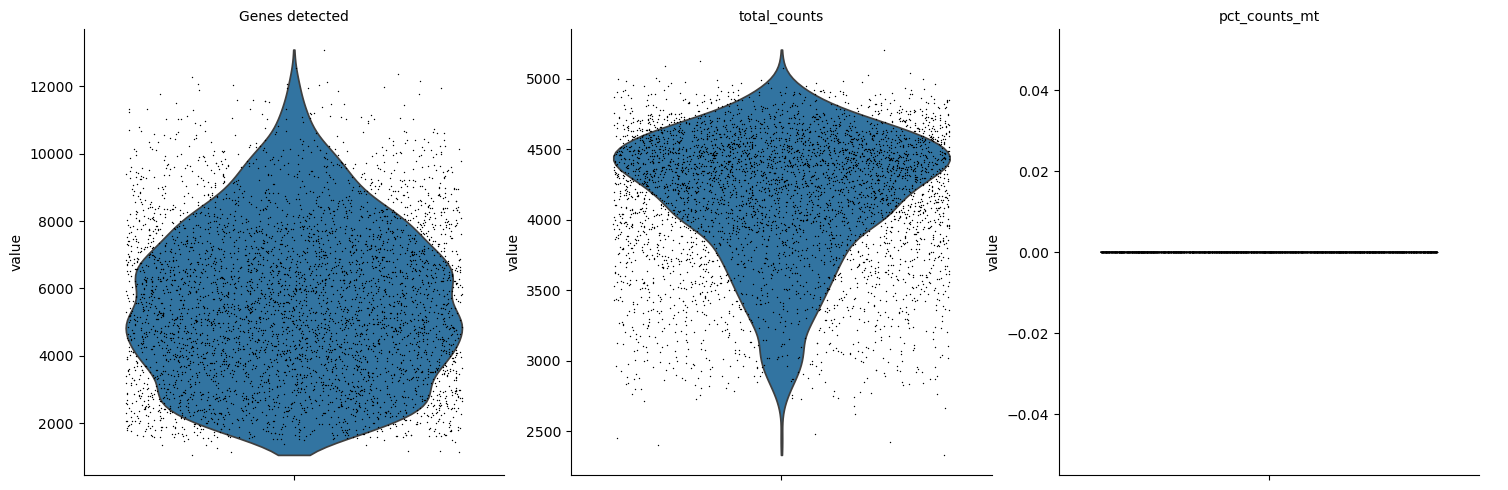

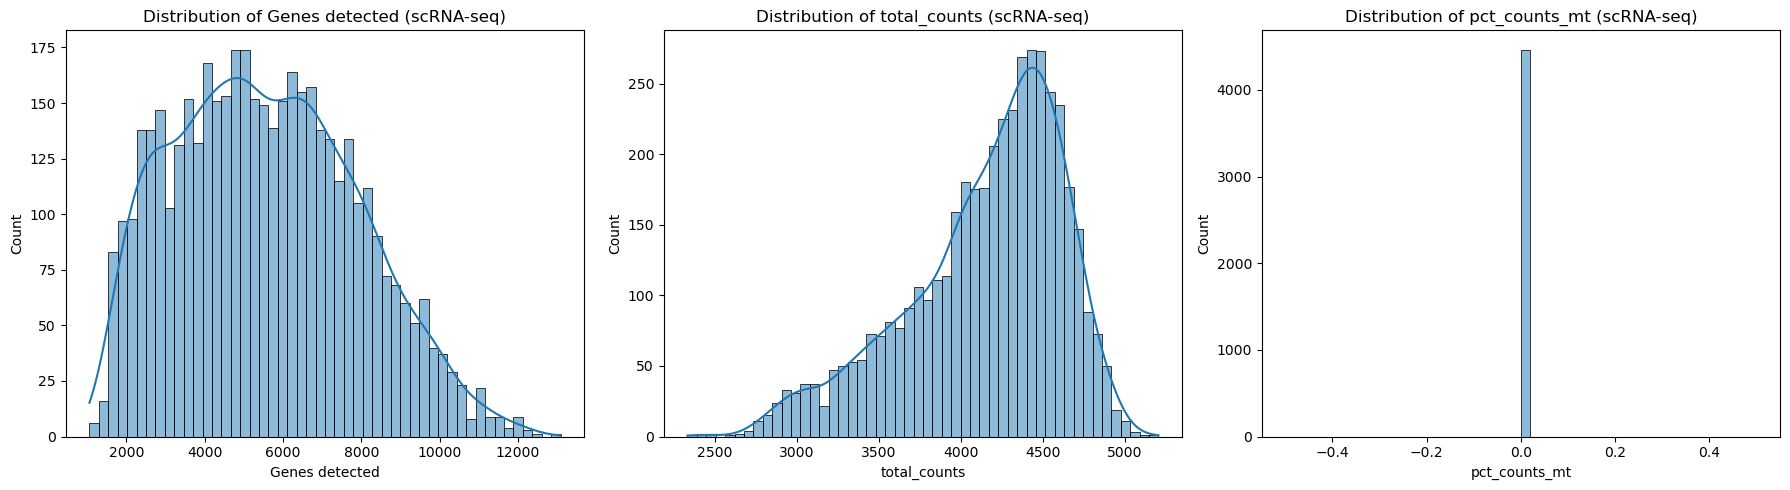

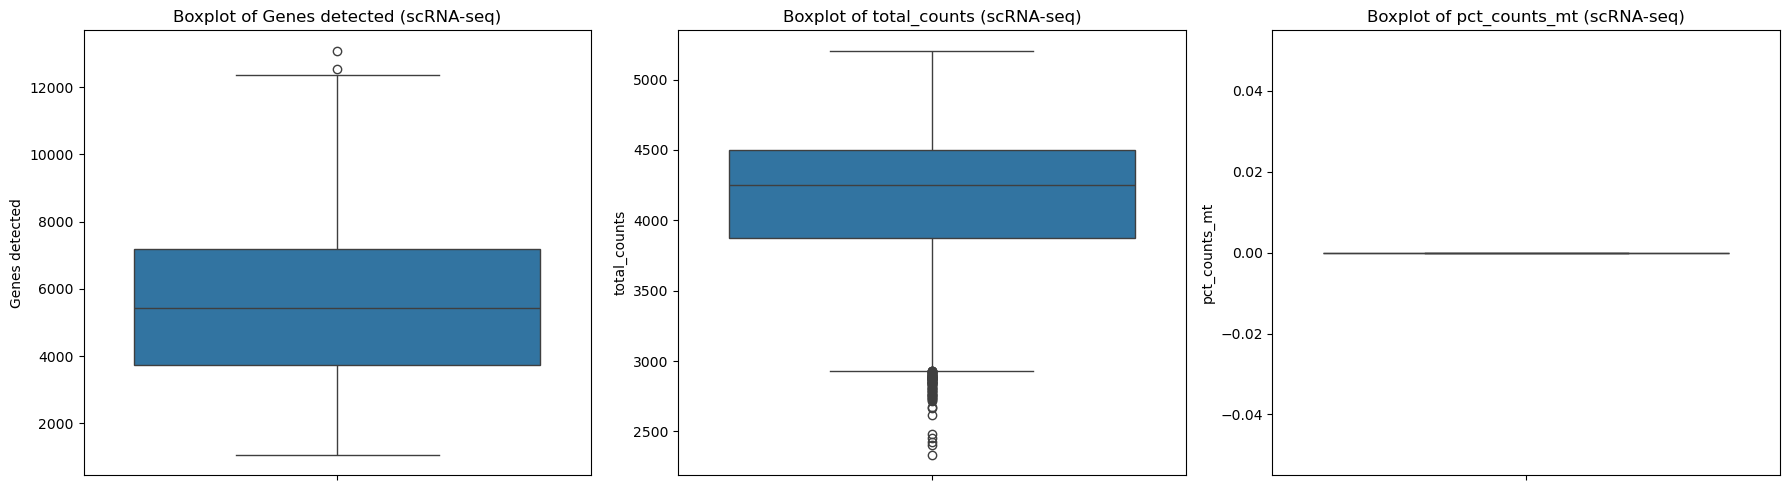

Generating violin plots for snRNA-seq after mitochondrial gene filtering...


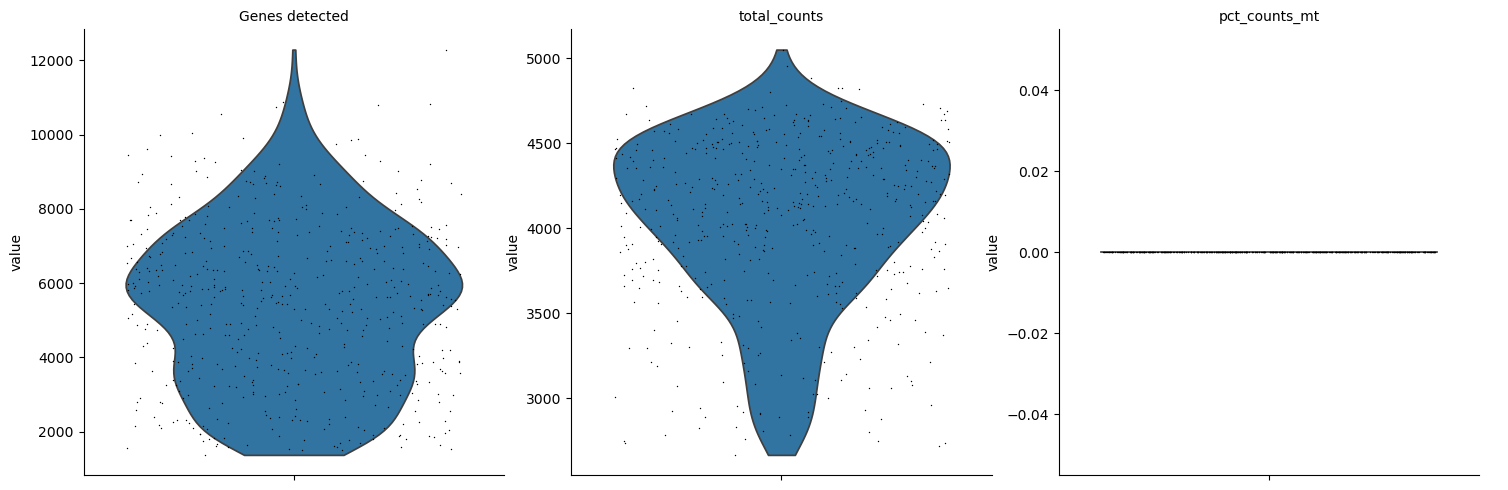

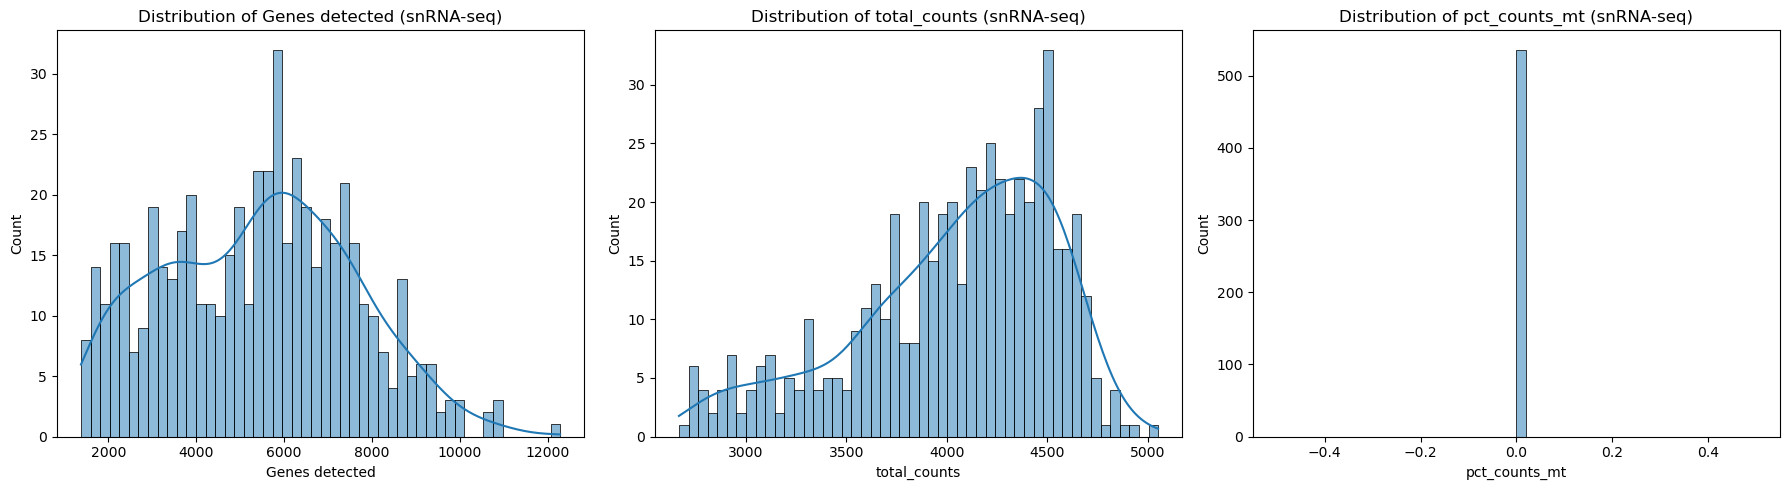

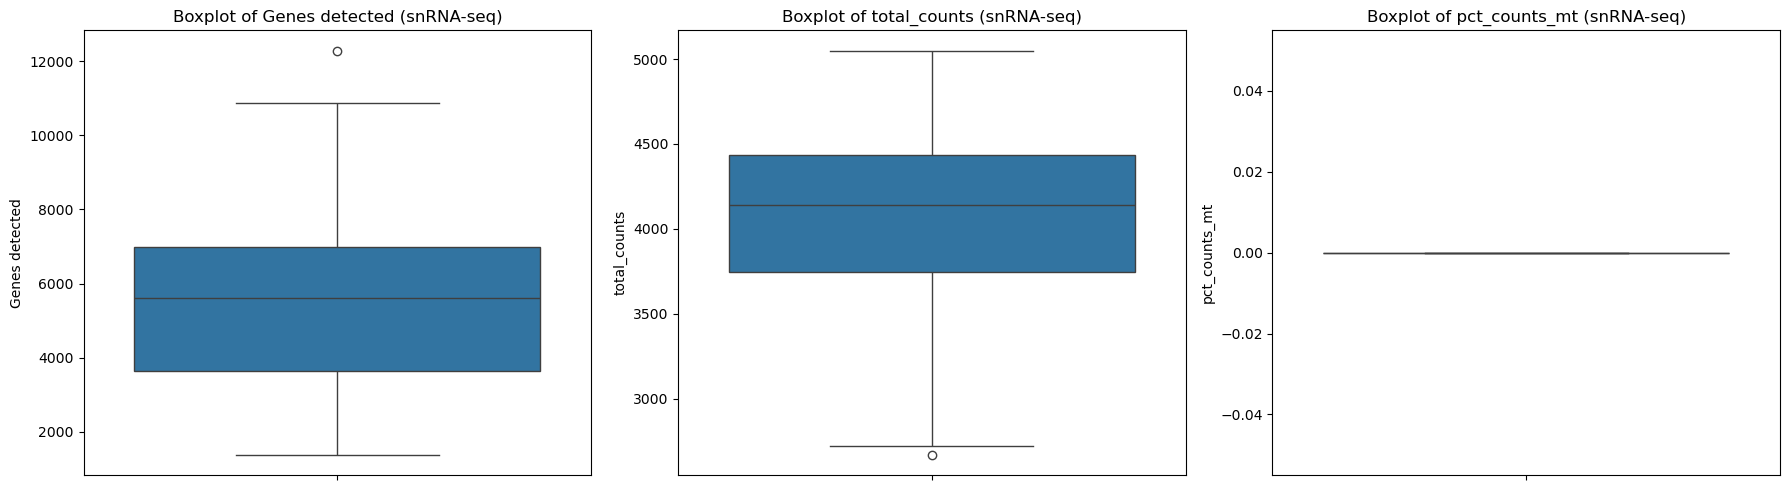

In [25]:
# Visualize metrics after mitochondrial gene filtering for scRNA-seq
print("Generating violin plots for scRNA-seq after mitochondrial gene filtering...")
sc.pl.violin(
    adata_scrna,
    ["Genes detected", "total_counts", "pct_counts_mt"],
    jitter=0.4, multi_panel=True
)

# Plot updated histograms for scRNA-seq
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(["Genes detected", "total_counts", "pct_counts_mt"]):
    sns.histplot(adata_scrna.obs[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col} (scRNA-seq)")
plt.tight_layout()
plt.show()

# Plot updated boxplots for scRNA-seq
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(["Genes detected", "total_counts", "pct_counts_mt"]):
    sns.boxplot(y=adata_scrna.obs[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} (scRNA-seq)")
plt.tight_layout()
plt.show()


# Visualize metrics after mitochondrial gene filtering for snRNA-seq
print("Generating violin plots for snRNA-seq after mitochondrial gene filtering...")
sc.pl.violin(
    adata_snrna,
    ["Genes detected", "total_counts", "pct_counts_mt"],
    jitter=0.4, multi_panel=True
)

# Plot updated histograms for snRNA-seq
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(["Genes detected", "total_counts", "pct_counts_mt"]):
    sns.histplot(adata_snrna.obs[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col} (snRNA-seq)")
plt.tight_layout()
plt.show()

# Plot updated boxplots for snRNA-seq
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(["Genes detected", "total_counts", "pct_counts_mt"]):
    sns.boxplot(y=adata_snrna.obs[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col} (snRNA-seq)")
plt.tight_layout()
plt.show()

In [26]:
# Compute quantiles
quantiles_scrna = adata_scrna.obs[["Genes detected", "total_counts"]].quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
quantiles_snrna = adata_snrna.obs[["Genes detected", "total_counts"]].quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])

print("Quantiles for scRNA-seq:")
print(quantiles_scrna)

print("\nQuantiles for snRNA-seq:")
print(quantiles_snrna)

# Compute IQR method for outlier detection
def compute_iqr_bounds(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

iqr_bounds_scrna = {col: compute_iqr_bounds(adata_scrna.obs, col) for col in ["Genes detected", "total_counts"]}
iqr_bounds_snrna = {col: compute_iqr_bounds(adata_snrna.obs, col) for col in ["Genes detected", "total_counts"]}

print("\nIQR Bounds for scRNA-seq:")
print(iqr_bounds_scrna)

print("\nIQR Bounds for snRNA-seq:")
print(iqr_bounds_snrna)

# Compute log-transformed percentiles for total_counts
adata_scrna.obs["log_total_counts"] = np.log1p(adata_scrna.obs["total_counts"])
adata_snrna.obs["log_total_counts"] = np.log1p(adata_snrna.obs["total_counts"])

log_quantiles_scrna = adata_scrna.obs["log_total_counts"].quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
log_quantiles_snrna = adata_snrna.obs["log_total_counts"].quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])

print("\nLog-Transformed Quantiles for scRNA-seq (log_total_counts):")
print(log_quantiles_scrna)

print("\nLog-Transformed Quantiles for snRNA-seq (log_total_counts):")
print(log_quantiles_snrna)


Quantiles for scRNA-seq:
      Genes detected  total_counts
0.01         1619.63   2871.950525
0.05         2075.30   3202.335779
0.25         3720.00   3873.224609
0.50         5415.50   4250.968262
0.75         7199.50   4500.764648
0.95         9621.85   4753.626611
0.99        11072.74   4905.596436

Quantiles for snRNA-seq:
      Genes detected  total_counts
0.01         1576.60   2754.558765
0.05         1891.50   3005.657898
0.25         3641.00   3743.536865
0.50         5606.50   4142.268311
0.75         6990.25   4436.603394
0.95         8916.50   4657.474487
0.99        10378.65   4821.168579

IQR Bounds for scRNA-seq:
{'Genes detected': (-1499.25, 12418.75), 'total_counts': (2931.91455078125, 5442.07470703125)}

IQR Bounds for snRNA-seq:
{'Genes detected': (-1382.875, 12014.125), 'total_counts': (2703.9370727539062, 5476.203186035156)}

Log-Transformed Quantiles for scRNA-seq (log_total_counts):
0.01    7.963095
0.05    8.071948
0.25    8.262101
0.50    8.355137
0.75    8.4

Number of cells after filtering in scRNA-seq: 4244


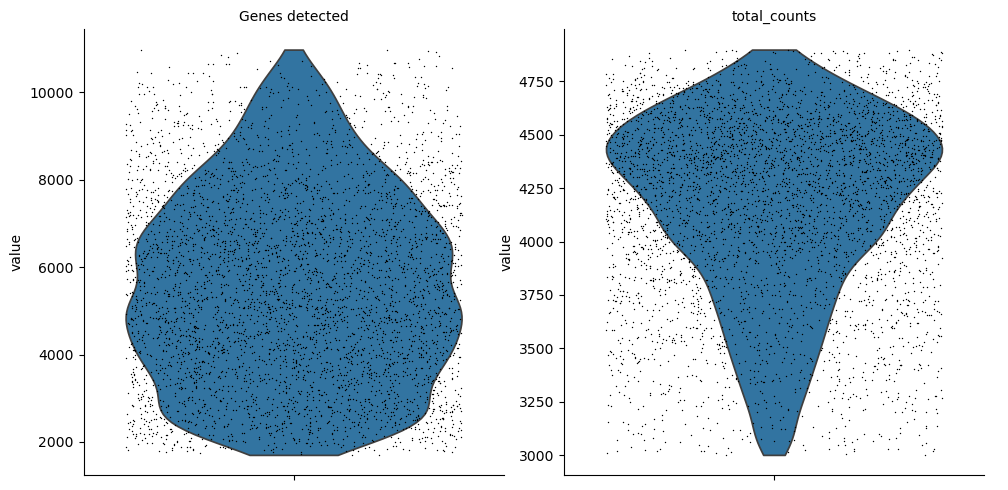

Descriptive statistics after filtering in scRNA-seq:
       Genes detected  total_counts
count     4244.000000   4244.000000
mean      5560.178841   4167.293945
std       2158.968936    427.933777
min       1704.000000   3001.098633
25%       3837.000000   3909.645874
50%       5422.500000   4253.958008
75%       7121.250000   4492.537598
max      10980.000000   4898.698242
Number of nuclei after filtering in snRNA-seq: 511


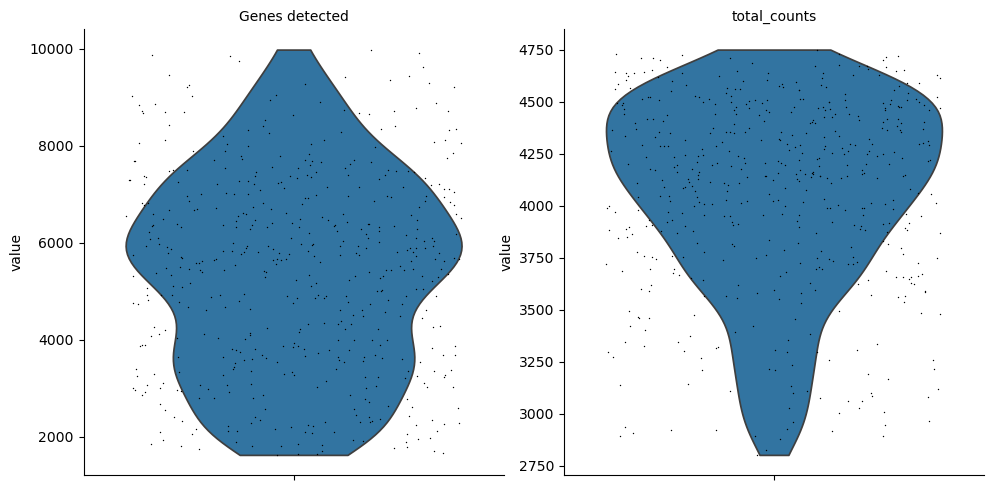

Descriptive statistics after filtering in snRNA-seq:
       Genes detected  total_counts
count      511.000000    511.000000
mean      5382.500978   4047.248535
std       2038.538268    460.725342
min       1624.000000   2801.148193
25%       3677.500000   3753.846313
50%       5582.000000   4141.795898
75%       6933.000000   4418.280029
max       9983.000000   4750.015625


In [27]:
# Define quality thresholds for scRNA-seq
min_genes_scrna = 1700   # Minimum number of detected genes
max_genes_scrna = 11000  # Maximum number of detected genes
min_counts_scrna = 3000  # Minimum total RNA counts
max_counts_scrna = 4900  # Maximum total RNA counts
max_pct_mt_scrna = 10    # Maximum mitochondrial RNA percentage

# Apply filtering for scRNA-seq
adata_scrna = adata_scrna[
    (adata_scrna.obs["Genes detected"] > min_genes_scrna) &
    (adata_scrna.obs["Genes detected"] < max_genes_scrna) &
    (adata_scrna.obs["total_counts"] > min_counts_scrna) &
    (adata_scrna.obs["total_counts"] < max_counts_scrna) &
    (adata_scrna.obs["pct_counts_mt"] < max_pct_mt_scrna)
]

# Confirm number of cells after filtering in scRNA-seq
print(f"Number of cells after filtering in scRNA-seq: {adata_scrna.shape[0]}")

# Visualize the distribution after filtering in scRNA-seq
sc.pl.violin(
    adata_scrna, ["Genes detected", "total_counts"], 
    jitter=0.4, multi_panel=True
)

# Generate descriptive statistics after filtering in scRNA-seq
print("Descriptive statistics after filtering in scRNA-seq:")
print(adata_scrna.obs[["Genes detected", "total_counts"]].describe())


# Define quality thresholds for snRNA-seq
min_genes_snrna = 1600   # Minimum number of detected genes
max_genes_snrna = 10000  # Maximum number of detected genes
min_counts_snrna = 2800  # Minimum total RNA counts
max_counts_snrna = 4800  # Maximum total RNA counts
max_pct_mt_snrna = 12    # Maximum mitochondrial RNA percentage

# Apply filtering for snRNA-seq
adata_snrna = adata_snrna[
    (adata_snrna.obs["Genes detected"] > min_genes_snrna) &
    (adata_snrna.obs["Genes detected"] < max_genes_snrna) &
    (adata_snrna.obs["total_counts"] > min_counts_snrna) &
    (adata_snrna.obs["total_counts"] < max_counts_snrna) &
    (adata_snrna.obs["pct_counts_mt"] < max_pct_mt_snrna)
]

# Confirm number of nuclei after filtering in snRNA-seq
print(f"Number of nuclei after filtering in snRNA-seq: {adata_snrna.shape[0]}")

# Visualize the distribution after filtering in snRNA-seq
sc.pl.violin(
    adata_snrna, ["Genes detected", "total_counts"], 
    jitter=0.4, multi_panel=True
)

# Generate descriptive statistics after filtering in snRNA-seq
print("Descriptive statistics after filtering in snRNA-seq:")
print(adata_snrna.obs[["Genes detected", "total_counts"]].describe())

In [28]:
# Convert to an explicit copy to avoid warnings
adata_scrna = adata_scrna.copy()
adata_snrna = adata_snrna.copy()

# Total normalization (without log transformation) for scRNA-seq
sc.pp.normalize_total(adata_scrna, target_sum=1e4, inplace=True)
print("Normalization applied successfully to scRNA-seq.")

# Total normalization (without log transformation) for snRNA-seq
sc.pp.normalize_total(adata_snrna, target_sum=1e4, inplace=True)
print("Normalization applied successfully to snRNA-seq.")

# Fix: Update total_counts in obs to reflect normalization 
adata_scrna.obs["total_counts"] = adata_scrna.X.sum(axis=1)
adata_snrna.obs["total_counts"] = adata_snrna.X.sum(axis=1)

# Verify the correction
print("Updated total_counts in scRNA-seq:")
print(adata_scrna.obs["total_counts"].describe())

print("\nUpdated total_counts in snRNA-seq:")
print(adata_snrna.obs["total_counts"].describe())

Normalization applied successfully to scRNA-seq.
Normalization applied successfully to snRNA-seq.
Updated total_counts in scRNA-seq:
count     4244.000000
mean     10000.000000
std          0.000928
min       9999.997070
25%       9999.999023
50%      10000.000000
75%      10000.000977
max      10000.002930
Name: total_counts, dtype: float64

Updated total_counts in snRNA-seq:
count      511.000000
mean     10000.000000
std          0.000886
min       9999.997070
25%       9999.999023
50%      10000.000000
75%      10000.000977
max      10000.001953
Name: total_counts, dtype: float64


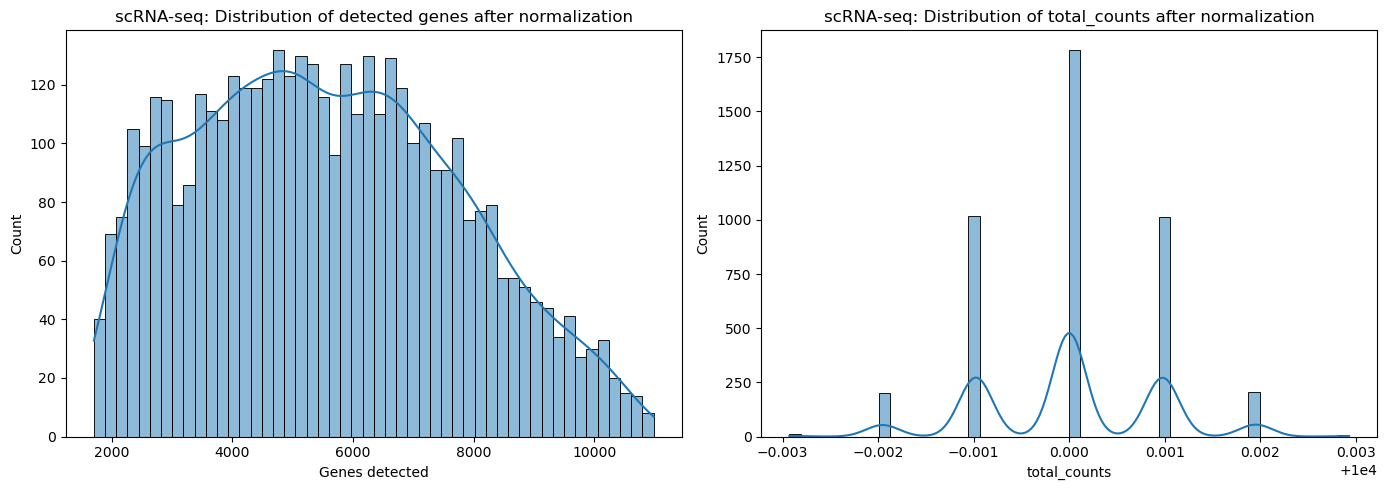

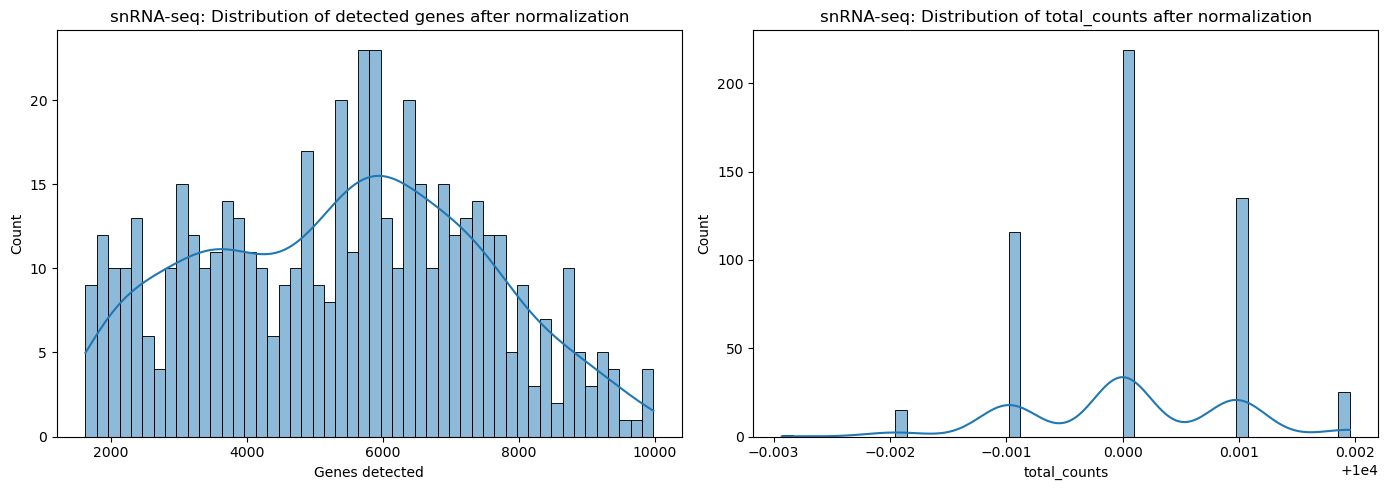

In [29]:
# Create histograms for scRNA-seq and snRNA-seq
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# scRNA-seq
sns.histplot(adata_scrna.obs["Genes detected"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("scRNA-seq: Distribution of detected genes after normalization")

sns.histplot(adata_scrna.obs["total_counts"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("scRNA-seq: Distribution of total_counts after normalization")

plt.tight_layout()
plt.show()

# Create histograms for snRNA-seq
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(adata_snrna.obs["Genes detected"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("snRNA-seq: Distribution of detected genes after normalization")

sns.histplot(adata_snrna.obs["total_counts"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("snRNA-seq: Distribution of total_counts after normalization")

plt.tight_layout()
plt.show()

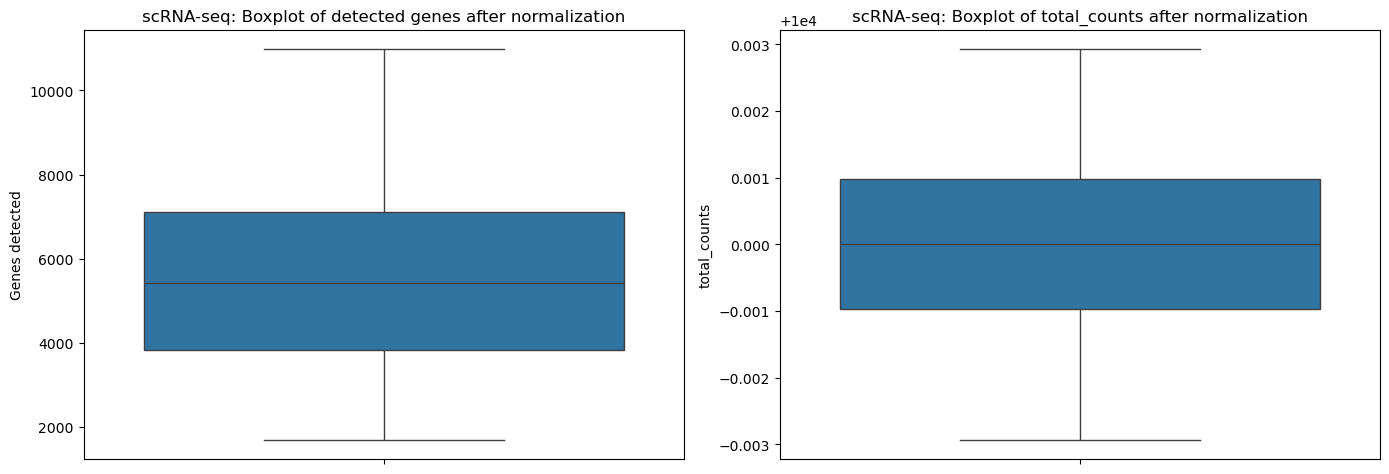

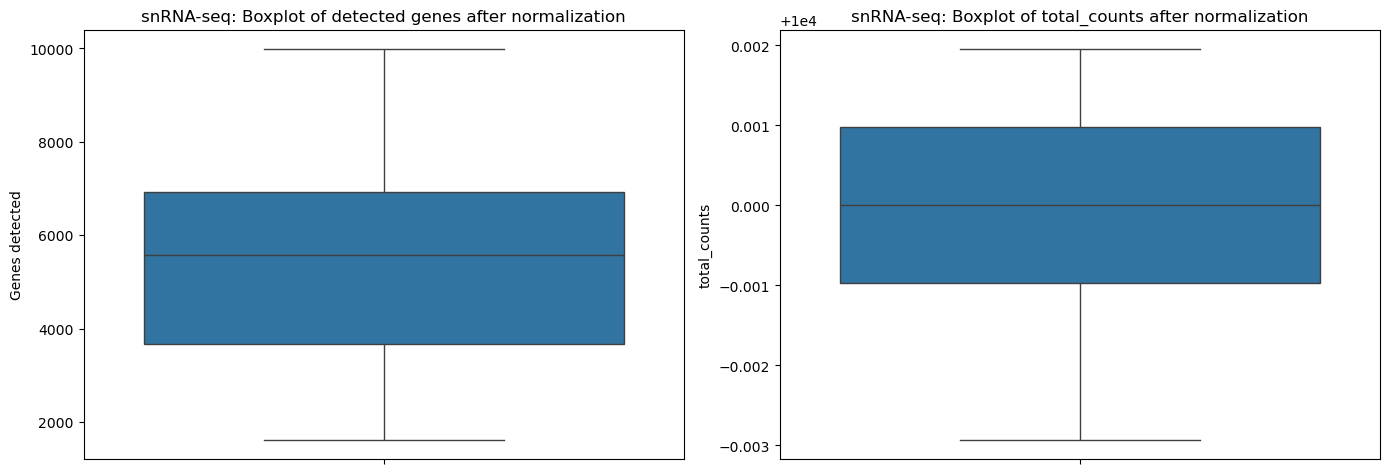

In [30]:
# Boxplots for scRNA-seq
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(y=adata_scrna.obs["Genes detected"], ax=axes[0])
axes[0].set_title("scRNA-seq: Boxplot of detected genes after normalization")

sns.boxplot(y=adata_scrna.obs["total_counts"], ax=axes[1])
axes[1].set_title("scRNA-seq: Boxplot of total_counts after normalization")

plt.tight_layout()
plt.show()

# Boxplots for snRNA-seq
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(y=adata_snrna.obs["Genes detected"], ax=axes[0])
axes[0].set_title("snRNA-seq: Boxplot of detected genes after normalization")

sns.boxplot(y=adata_snrna.obs["total_counts"], ax=axes[1])
axes[1].set_title("snRNA-seq: Boxplot of total_counts after normalization")

plt.tight_layout()
plt.show()

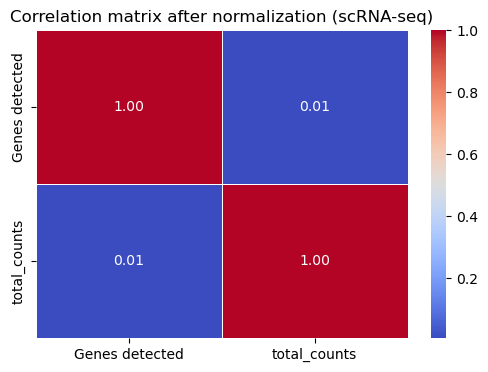

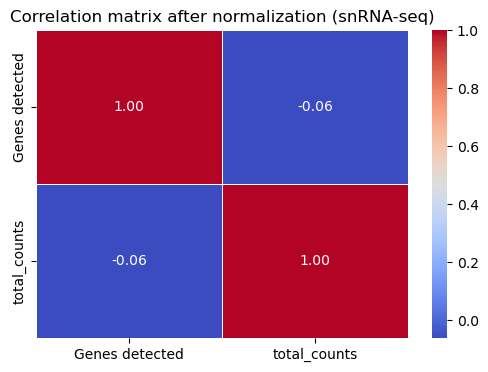

In [31]:
# Correlation matrix for scRNA-seq
corr_matrix_scrna = adata_scrna.obs[["Genes detected", "total_counts"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_scrna, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix after normalization (scRNA-seq)")
plt.show()

# Correlation matrix for snRNA-seq
corr_matrix_snrna = adata_snrna.obs[["Genes detected", "total_counts"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_snrna, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix after normalization (snRNA-seq)")
plt.show()